In [1]:
import os
import random
import monai.transforms as mt
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [3]:
def normalize(data):
    data = (data - data.mean()) / data.std()
    return data

tar_shape = [352, 352]
crop_shape = [224, 224]

In [12]:
class ACDC_2D(Dataset):
    def __init__(self, source, ind, Transform=None):
        # Initialize dataset properties
        self.source = Path(source)
        self.ind = ind if ind is not None else []
        
        # Define the default transform if none provided
        if Transform is not None:
            self.transform = Transform
        else:
            self.transform = mt.Compose([
                mt.AddChannel(),  # Add channel dimension
                mt.ScaleIntensity(),  # Normalize intensity values
                mt.ToTensor()  # Convert to PyTorch tensor
            ])
        
        # Load data paths
        self.data = self._load_data_paths()

    def _load_data_paths(self):
        data = []
        for patient_id in sorted(os.listdir(str(self.source))):
            patient_path = self.source / patient_id
            images_path = patient_path / "image"
            masks_path = patient_path / "mask"

            images = sorted(os.listdir(str(images_path)))
            masks = sorted(os.listdir(str(masks_path)))

            for img, mask in zip(images, masks):
                img_path = images_path / img
                mask_path = masks_path / mask
                if self.ind == [] or int(patient_id.replace("patient", "")) in self.ind:
                    data.append((img_path, mask_path))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, mask_path = self.data[idx]
        
        # Load the image and mask as NumPy arrays
        image = np.load(str(image_path))
        mask = np.load(str(mask_path))

        # Add a channel dimension to the image and mask
        image = np.expand_dims(image, axis=0)  # Converts from [H, W] to [C=1, H, W]
        mask = np.expand_dims(mask, axis=0)  # Converts from [H, W] to [C=1, H, W]

        # Normalize and prepare the data
        data = {"image": image, "mask": mask}
        if self.transform:
            data = self.transform(data)
        
        return data



In [16]:
def train_loader_ACDC(train_index, data_path=r"D:\Kodingan\Kodingan TA\database\\dataclean", transform=None):
    train_loader = ACDC_2D(source=data_path, Transform=transform, ind=train_index)
    return train_loader


def val_loader_ACDC(val_index, data_path=r"D:\Kodingan\Kodingan TA\database\testprocessed", transform=None):
    val_loader = ACDC_2D(source=data_path, Transform=transform, ind=val_index)
    return val_loader

In [18]:
train_compose = mt.Compose(
    [mt.ResizeWithPadOrCropD(keys=["image", "mask"], spatial_size=tar_shape, mode="constant"),
     mt.RandSpatialCropD(keys=["image", "mask"], roi_size=crop_shape, random_center=True, random_size=False),
     mt.Rand2DElasticD(
         keys=["image", "mask"],
         prob=0.25,
         spacing=(50, 50),
         magnitude_range=(1, 3),
         rotate_range=(np.pi / 4,),
         scale_range=(0.1, 0.1),
         translate_range=(10, 10),
         padding_mode="border",
     ),
     # mt.RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
     mt.RandFlipd(["image", "mask"], spatial_axis=[0], prob=0.5),
     mt.RandFlipd(["image", "mask"], spatial_axis=[1], prob=0.5),
     mt.RandRotateD(keys=["image", "mask"], range_x=np.pi / 4, range_y=np.pi / 4, range_z=0.0, prob=0.50,
                    keep_size=True, mode=("nearest", "nearest"), align_corners=False),
     mt.RandRotate90D(keys=["image", "mask"], prob=0.25, spatial_axes=(0, 1)),
     mt.RandGaussianNoiseD(keys=["image"], prob=0.15, std=0.01),
     mt.ToTensorD(keys=["image", "mask"], allow_missing_keys=False),
     mt.RandZoomd(
         keys=["image", "mask"],
         min_zoom=0.9,
         max_zoom=1.2,
         mode="nearest",
         align_corners=None,
         prob=0.25,
     ),
     mt.RandKSpaceSpikeNoiseD(keys=["image"], prob=0.15, intensity_range=(5.0, 7.5)),
     ]
)

val_compose = mt.Compose(
    [
        mt.ToTensorD(keys=["image", "mask"], allow_missing_keys=False),
    ]
)

test_compose = mt.Compose(
    [
        mt.DivisiblePadD(keys=["image", "mask"], k=(16, 16), mode="edge"),
        mt.ToTensorD(keys=["image", "mask"], allow_missing_keys=False),
    ]
)

splits = KFold(n_splits=5, shuffle=True, random_state=4)

concatenated_dataset = train_loader_ACDC(transform=None, train_index=None)

-------------------------- Fold 1 --------------------------
train from here
(5, 1, 224, 224) (5, 1, 224, 224)


C:\Users\Nabil\AppData\Local\Temp\ipykernel_18088\2885817744.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.ind == [] or int(patient_id.replace("patient", "")) in self.ind:


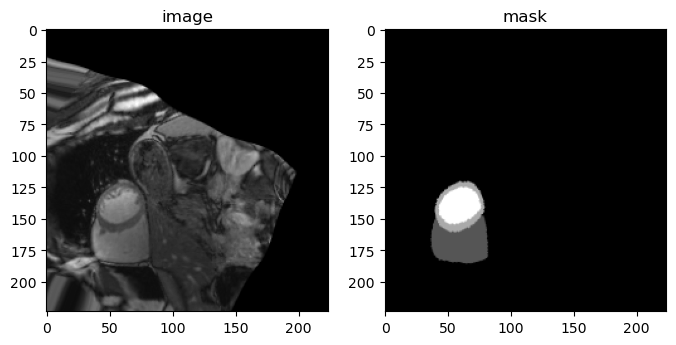

(5, 1, 224, 224) (5, 1, 224, 224)


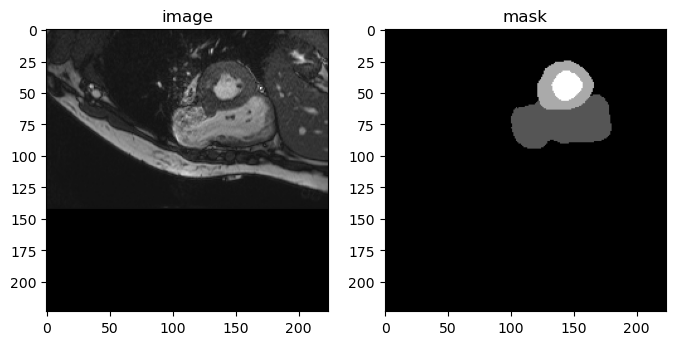

(5, 1, 224, 224) (5, 1, 224, 224)


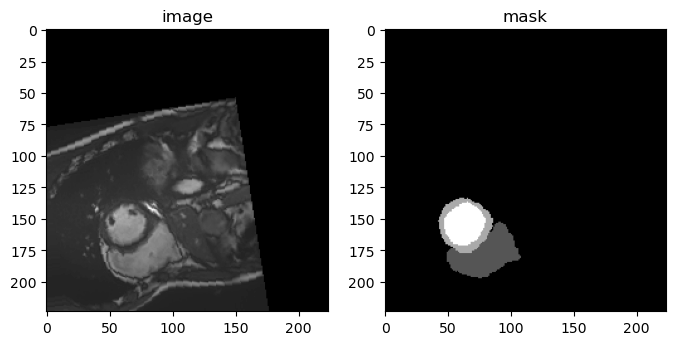

(5, 1, 224, 224) (5, 1, 224, 224)


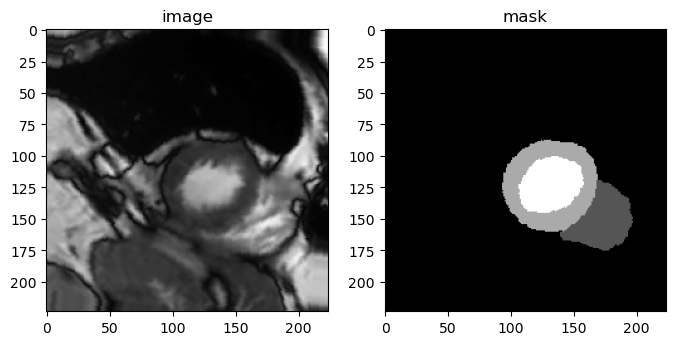

(5, 1, 224, 224) (5, 1, 224, 224)


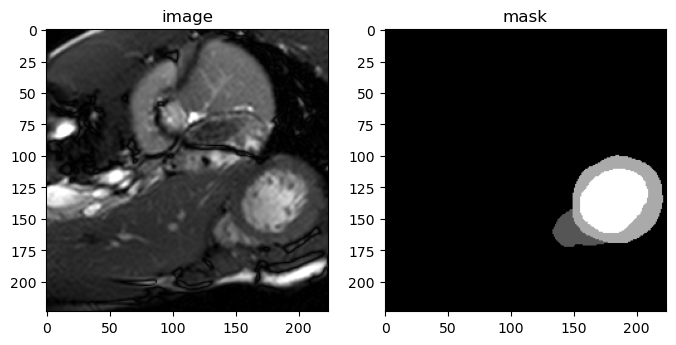

(5, 1, 224, 224) (5, 1, 224, 224)


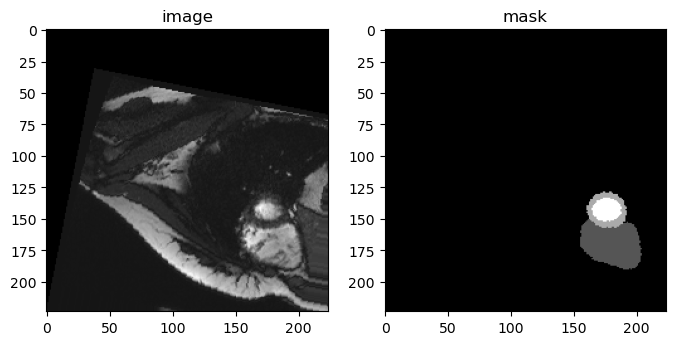

(5, 1, 224, 224) (5, 1, 224, 224)


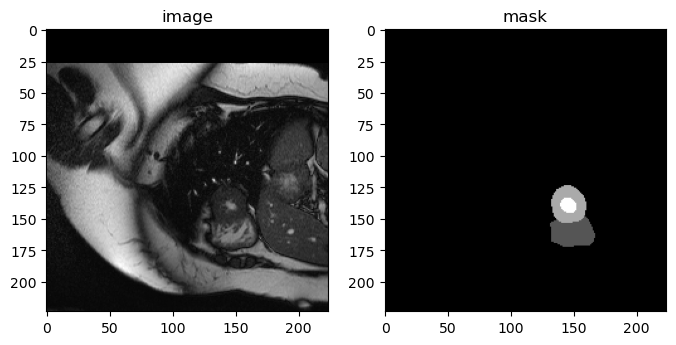

(5, 1, 224, 224) (5, 1, 224, 224)


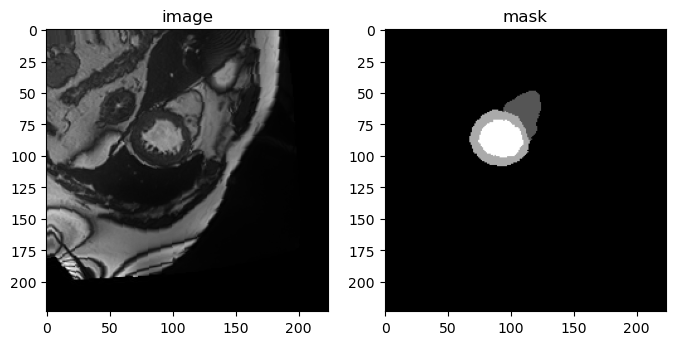

(5, 1, 224, 224) (5, 1, 224, 224)


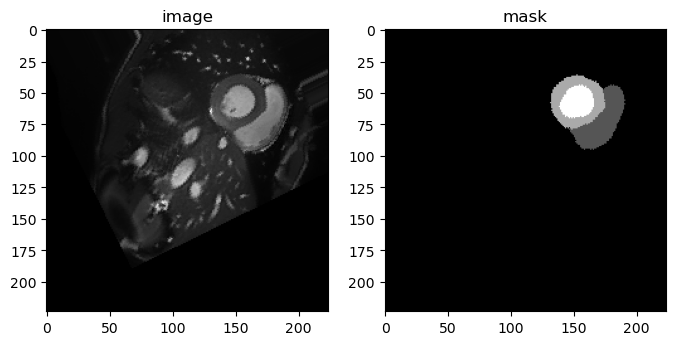

(5, 1, 224, 224) (5, 1, 224, 224)


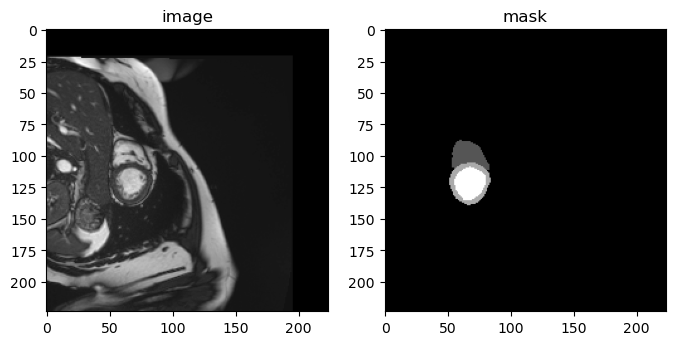

(5, 1, 224, 224) (5, 1, 224, 224)


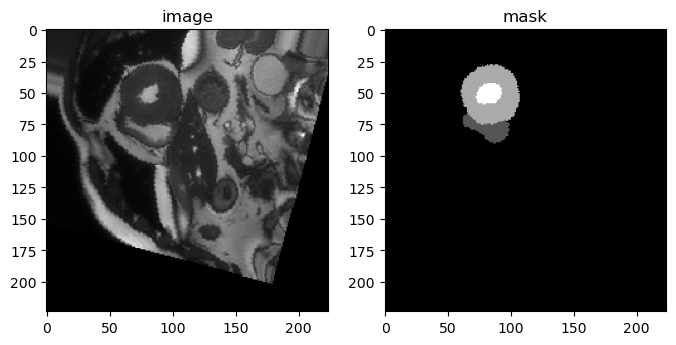

(5, 1, 224, 224) (5, 1, 224, 224)


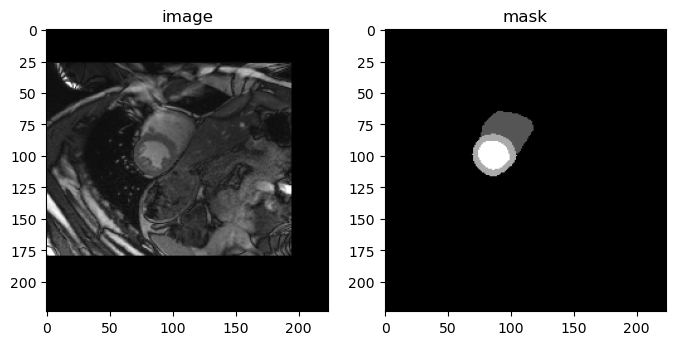

(5, 1, 224, 224) (5, 1, 224, 224)


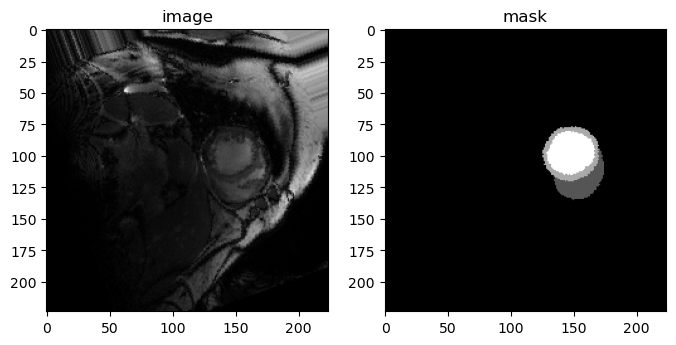

(5, 1, 224, 224) (5, 1, 224, 224)


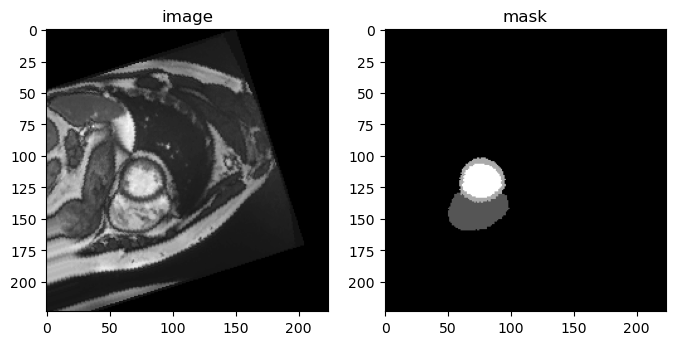

(5, 1, 224, 224) (5, 1, 224, 224)


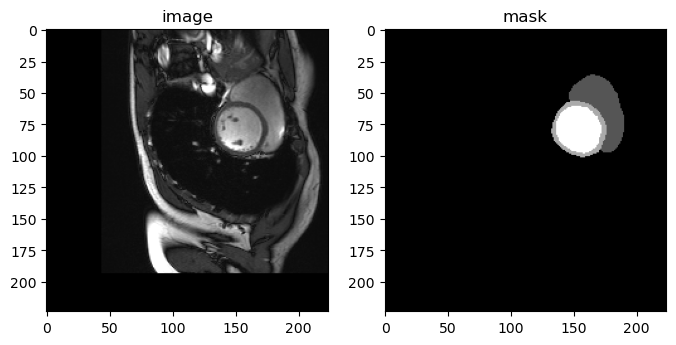

(5, 1, 224, 224) (5, 1, 224, 224)


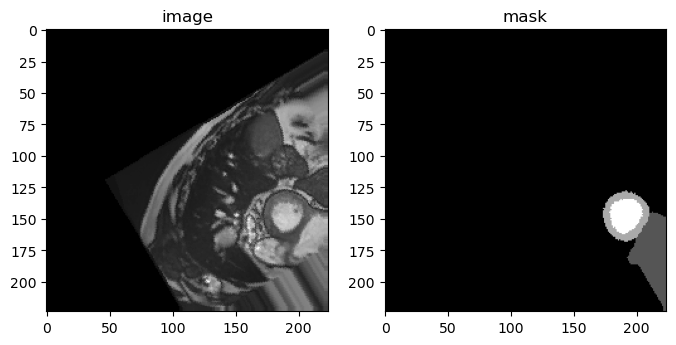

(5, 1, 224, 224) (5, 1, 224, 224)


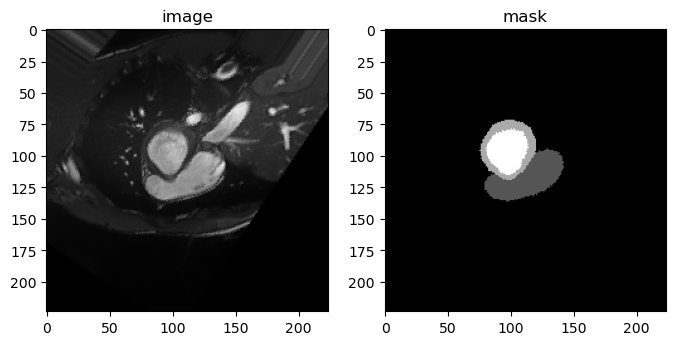

(5, 1, 224, 224) (5, 1, 224, 224)


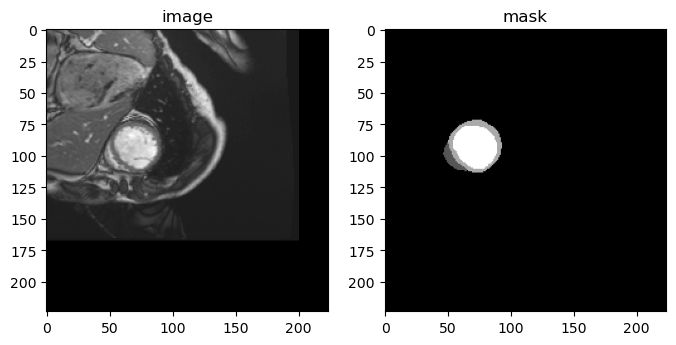

(5, 1, 224, 224) (5, 1, 224, 224)


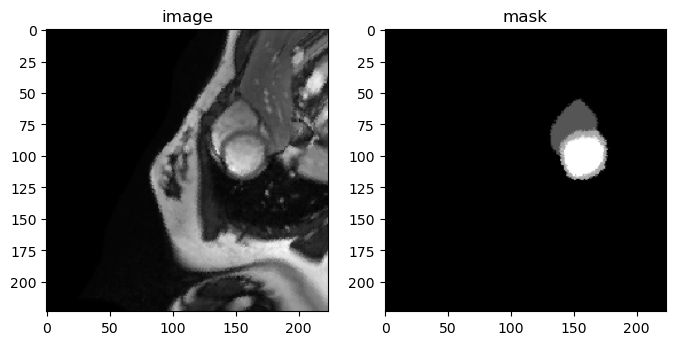

(5, 1, 224, 224) (5, 1, 224, 224)


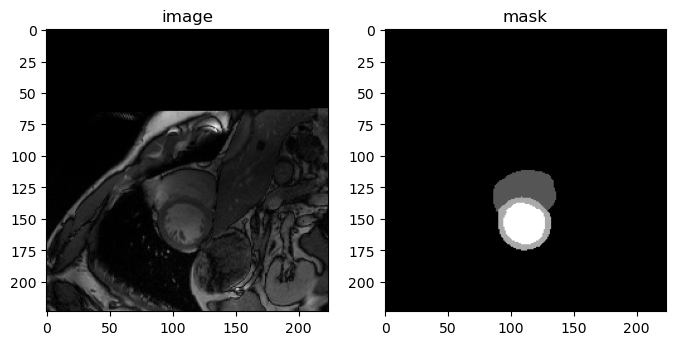

(5, 1, 224, 224) (5, 1, 224, 224)


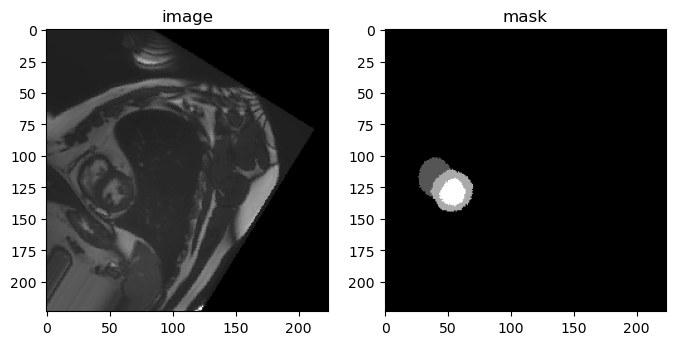

(5, 1, 224, 224) (5, 1, 224, 224)


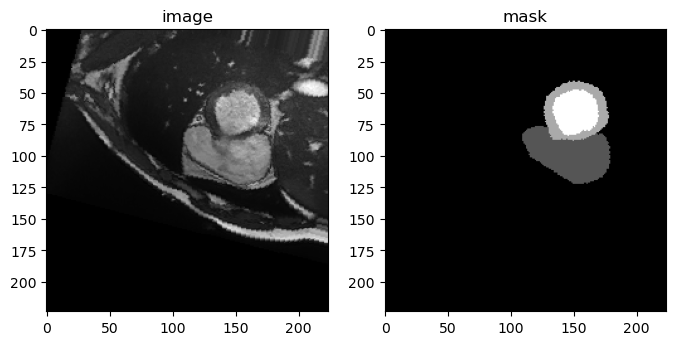

(5, 1, 224, 224) (5, 1, 224, 224)


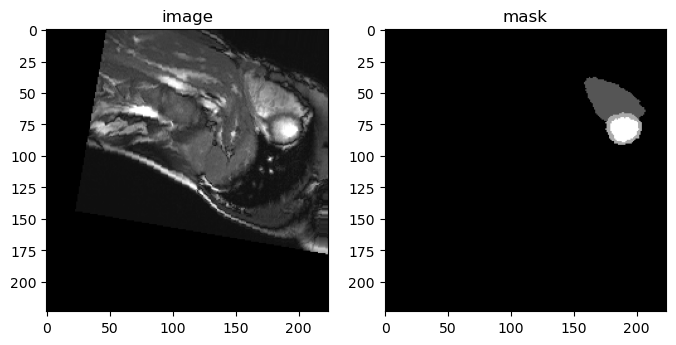

(5, 1, 224, 224) (5, 1, 224, 224)


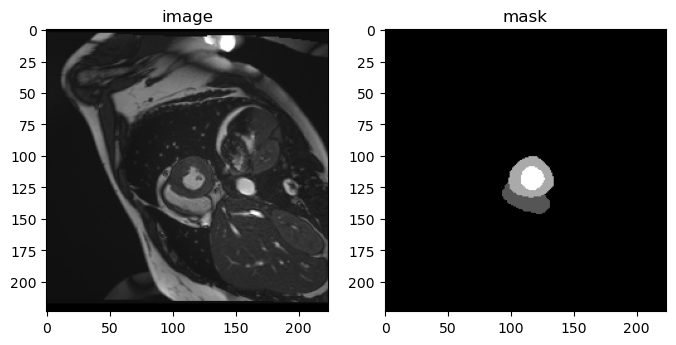

(5, 1, 224, 224) (5, 1, 224, 224)


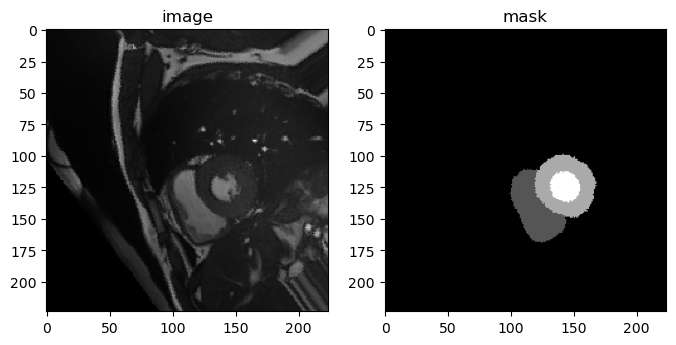

-------------------------- Fold 2 --------------------------
train from here
(5, 1, 224, 224) (5, 1, 224, 224)


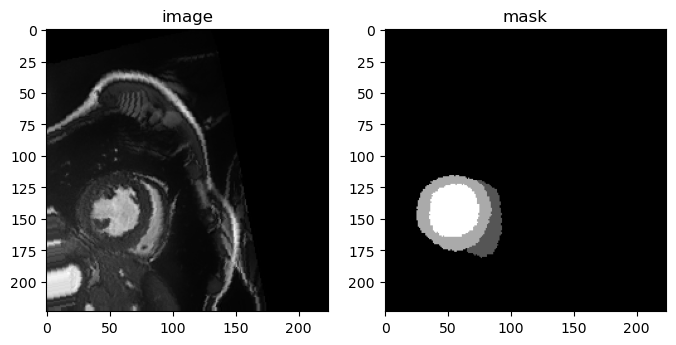

(5, 1, 224, 224) (5, 1, 224, 224)


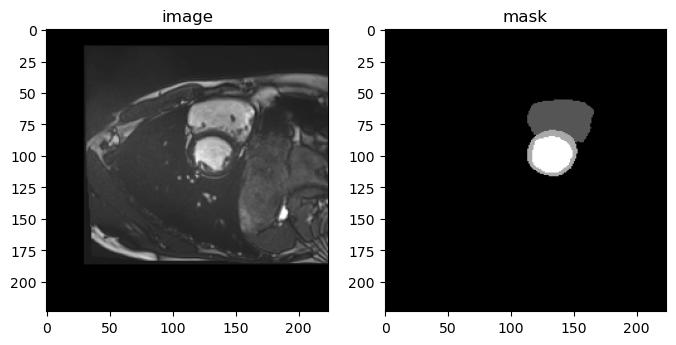

(5, 1, 224, 224) (5, 1, 224, 224)


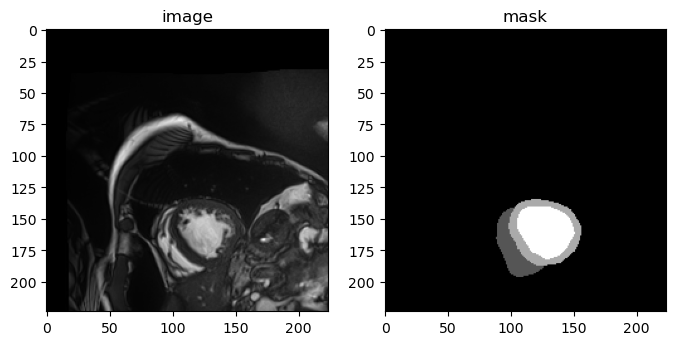

(5, 1, 224, 224) (5, 1, 224, 224)


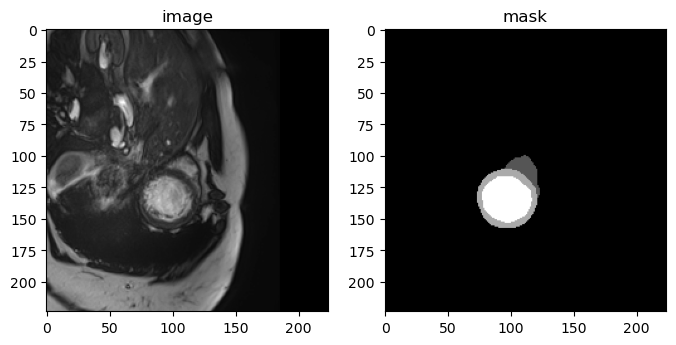

(5, 1, 224, 224) (5, 1, 224, 224)


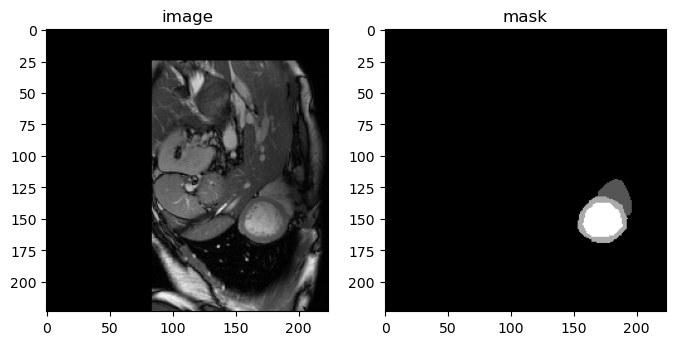

(5, 1, 224, 224) (5, 1, 224, 224)


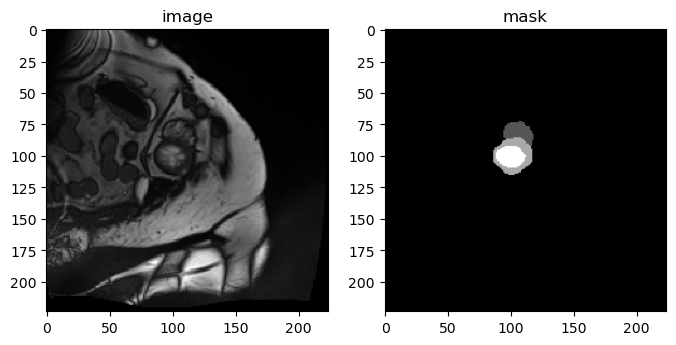

(5, 1, 224, 224) (5, 1, 224, 224)


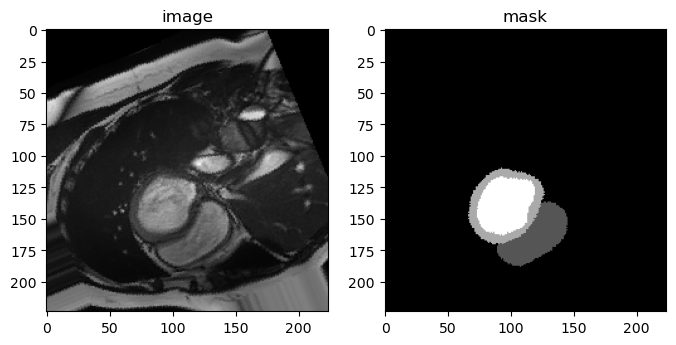

(5, 1, 224, 224) (5, 1, 224, 224)


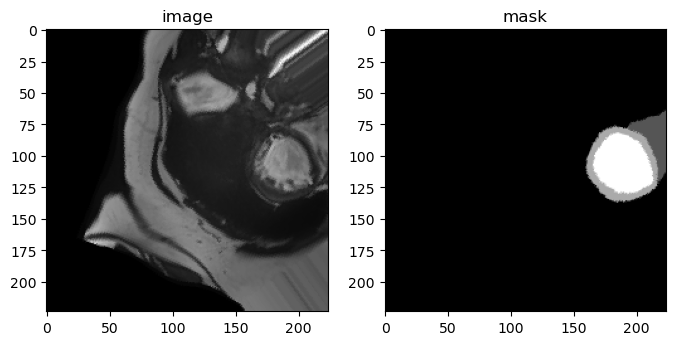

(5, 1, 224, 224) (5, 1, 224, 224)


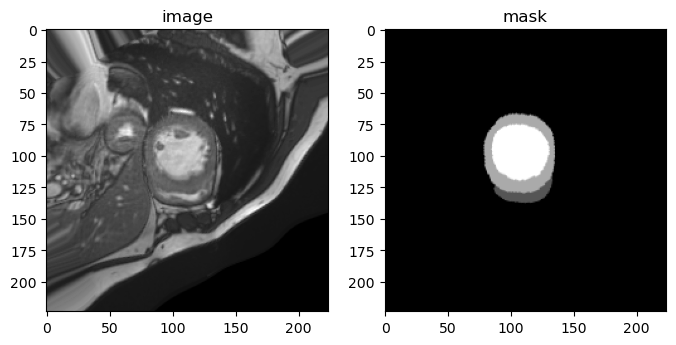

(5, 1, 224, 224) (5, 1, 224, 224)


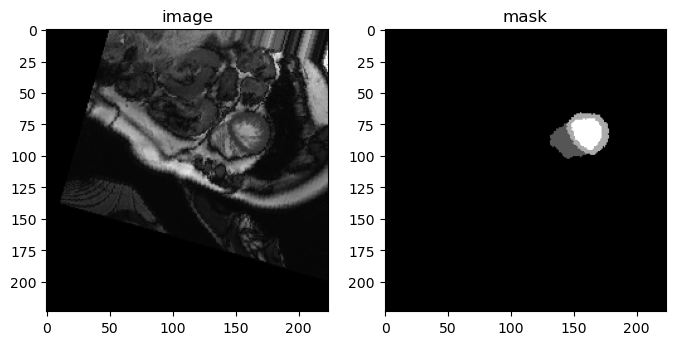

(5, 1, 224, 224) (5, 1, 224, 224)


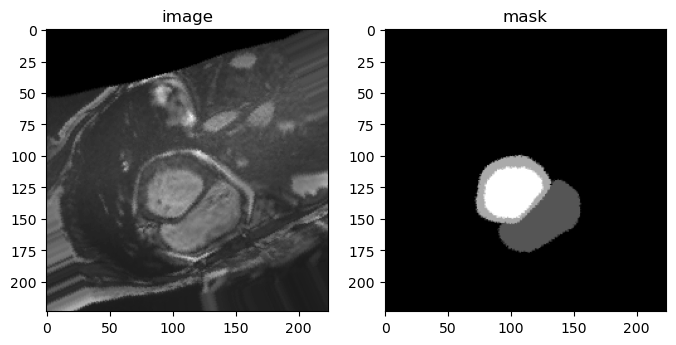

(5, 1, 224, 224) (5, 1, 224, 224)


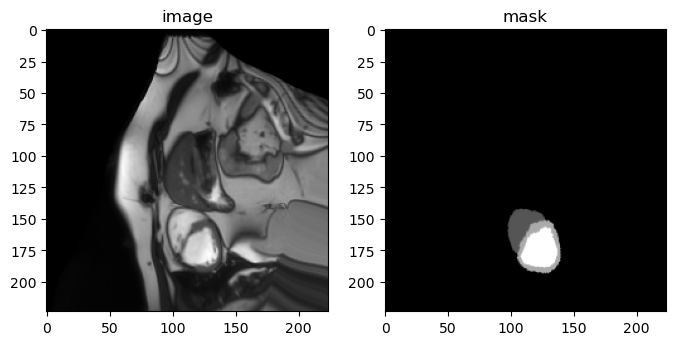

(5, 1, 224, 224) (5, 1, 224, 224)


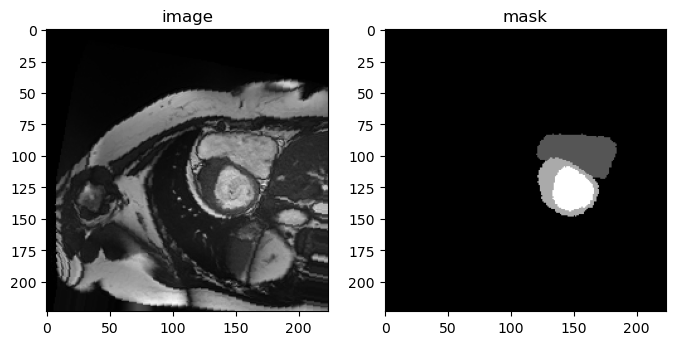

(5, 1, 224, 224) (5, 1, 224, 224)


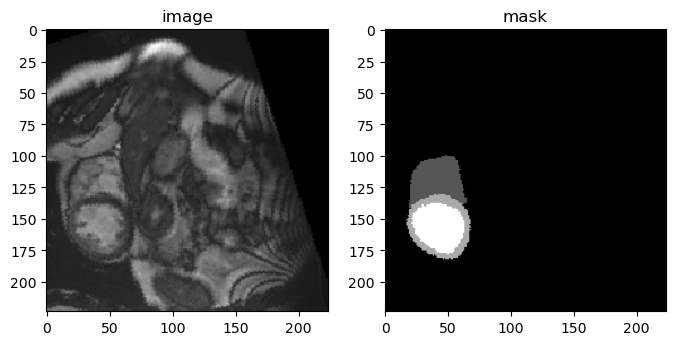

(5, 1, 224, 224) (5, 1, 224, 224)


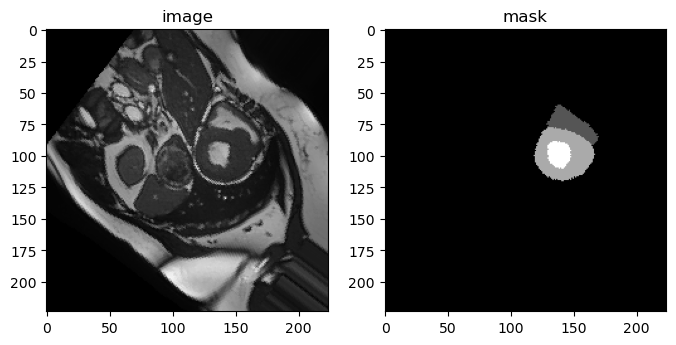

(5, 1, 224, 224) (5, 1, 224, 224)


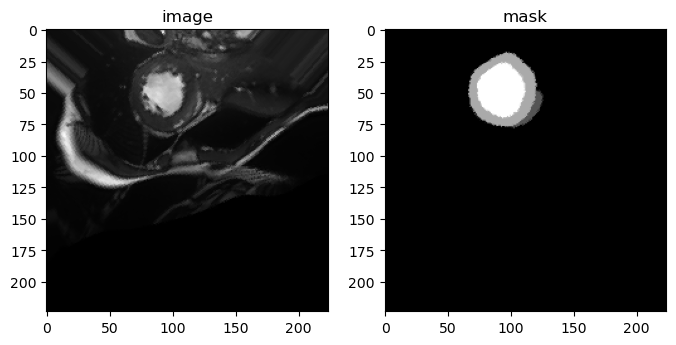

(5, 1, 224, 224) (5, 1, 224, 224)


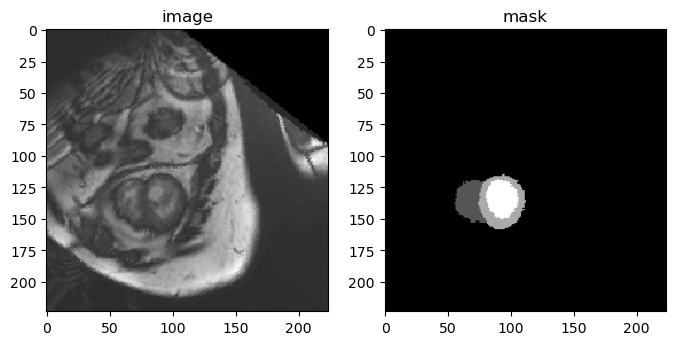

(5, 1, 224, 224) (5, 1, 224, 224)


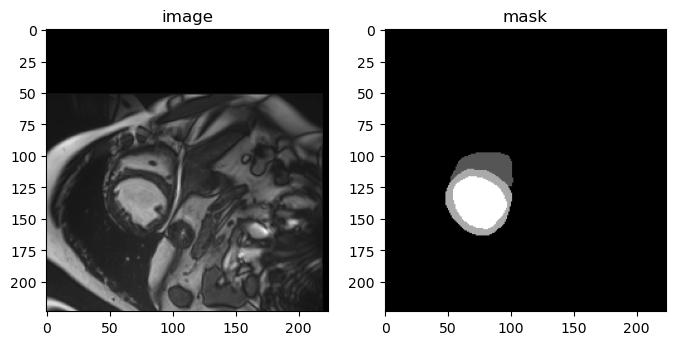

(5, 1, 224, 224) (5, 1, 224, 224)


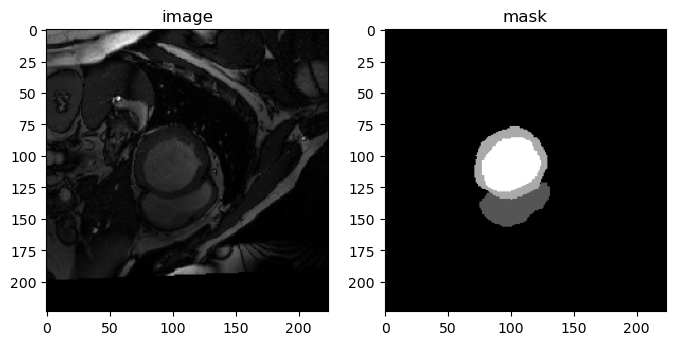

(5, 1, 224, 224) (5, 1, 224, 224)


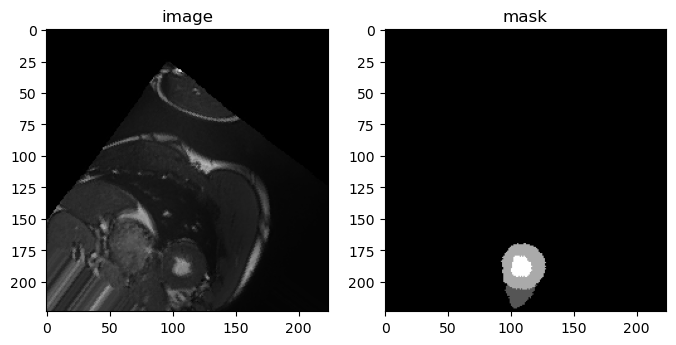

(5, 1, 224, 224) (5, 1, 224, 224)


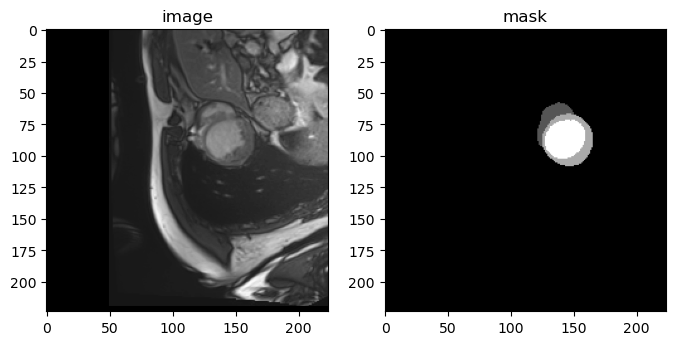

(5, 1, 224, 224) (5, 1, 224, 224)


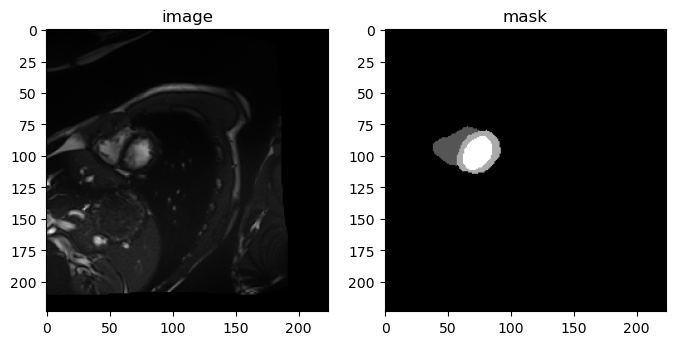

(5, 1, 224, 224) (5, 1, 224, 224)


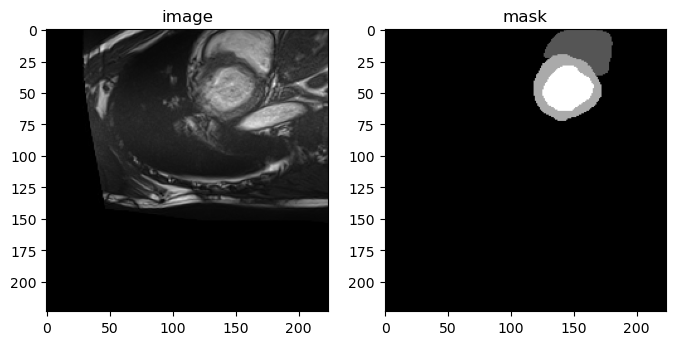

(5, 1, 224, 224) (5, 1, 224, 224)


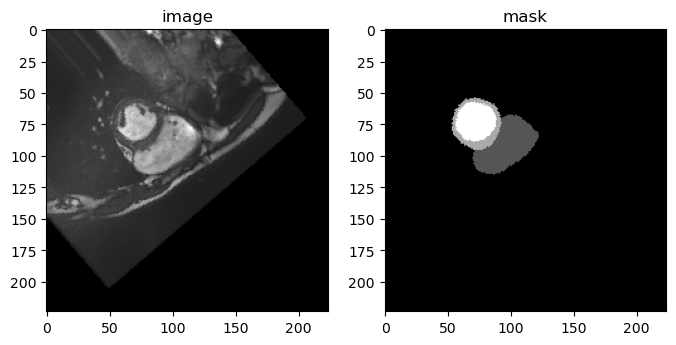

(5, 1, 224, 224) (5, 1, 224, 224)


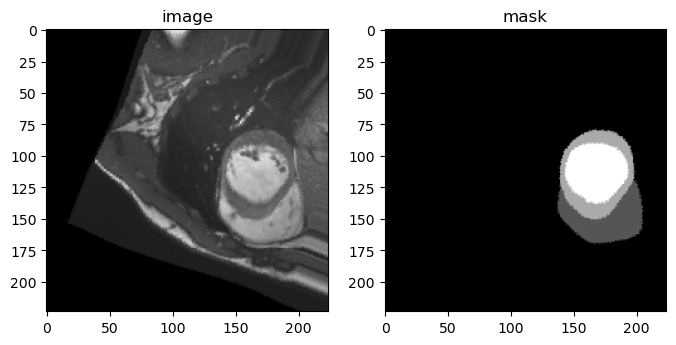

In [22]:
test_split = KFold(n_splits=2, shuffle=True, random_state=4)

for fold, (train_idx, val_idx) in enumerate(test_split.split(np.arange(len(concatenated_dataset)))):

    print("--------------------------", "Fold", fold + 1, "--------------------------")

    # training dataset
    training_data = DataLoader(train_loader_ACDC(transform=train_compose, train_index=train_idx), batch_size=5,
                               shuffle=True)
    print("train from here")
    image_counter = 0
    for dic in training_data:
        images = dic["image"]
        masks = dic["mask"]
        print(images.shape, masks.shape)
        image, label = dic["image"], dic["mask"]

        if image_counter < 25:
            plt.figure("visualise", (8, 4))
            plt.subplot(1, 2, 1)
            plt.title("image")
            plt.imshow(image[0, 0, :, :], cmap="gray")
            plt.subplot(1, 2, 2)
            plt.title("mask")
            plt.imshow(label[0, 0, :, :], cmap="gray")
            plt.show()
            image_counter += 1
        else :
            break

        if image_counter >= 25 :
            break